In [79]:
# === Configuration (change these between runs) ===
ion1 = -2
ion2 = 3
nions = 13
nseg = 25
file_suffix = "v2"

# Optimizer settings
params_file = "../system_params/072125_goldparams_13ions.json"
pitime = 8
τmin = 5
τmax = 15
maxtime = 10
min_mode_index = 1
max_mode_index = 2
println("Gate time between $(τmin * nseg) and $(τmax * nseg) μs")
println("Required pi time lower bound: $(pitime/cld(nseg+1, 2)) μs")

Gate time between 125 and 375 μs
Required pi time lower bound: 0.6153846153846154 μs


In [80]:
# === Setup (run once, rarely needs changes) ===
using GoldGates
using MSSim: Optimizers as Opts, SegSeq as SS, SymLinear as SL, Sequence as Seq, Utils as U
using NLopt
using Statistics
using PyPlot
using JSON
using Dates

include("../src/utils.jl")
ENV["MPLBACKEND"] = "module://matplotlib_inline.backend_inline"

sysparams = open(params_file) do io
    read(io, GoldGates.SystemParams; format=:json)
end

modes = setup_modes(sysparams, ion1, ion2, nions)
nlmodel = setup_model(nseg, modes)
opt, tracker = setup_optimizer(nlmodel, sysparams; pitime, τmin, τmax, maxtime, min_mode_index, max_mode_index)

date = Dates.format(Dates.now(), "yyyymmdd")
out_file = "../out/$(date)_am_$(nions)_$(file_suffix).json"

"../out/20260205_am_13_v2.json"

In [81]:
# === Optimize ===
best_params, best_obj = run_optimization!(opt, tracker, nlmodel)

(obj = 246.74011002723395, dis = 0.0, disδ = 0.0, area = 0.0, areaε = -1.5707963267948966, areaδ = 0.0, total_t = 199.89307341440926, Ωmax = 0.0)
(obj = 0.005327519785507106, dis = 2.169489579436394e-6, disδ = 0.5314652697458891, area = -1.5707793623595283, areaε = -1.6964435368249653e-5, areaδ = -14.109787185837229, total_t = 277.67821897732586, Ωmax = 0.0)
(obj = 0.0020456182859712345, dis = 1.2831967845846677e-6, disδ = 0.20367380512053412, area = -1.5707898075359392, areaε = -6.519258957338181e-6, areaδ = -15.684389593588962, total_t = 206.93203127149258, Ωmax = 0.0)
(obj = 0.001784313998547712, dis = 9.8692132097952e-7, disδ = 0.1769214333046472, area = -1.570790613989627, areaε = -5.712805269508792e-6, areaδ = -31.877570926808882, total_t = 375.0, Ωmax = 0.0)
(obj = 0.0009596543618234969, dis = 4.1062683630808243e-7, disδ = 0.09532183116371634, area = -1.5707932581536255, areaε = -3.0686412710867472e-6, areaδ = -20.933165906923843, total_t = 333.2230372519061, Ωmax = 4.5838198489

([13.151960188169356, 9.250581713368354e-6, 0.003317769912618712, 0.009857455448570787, 0.019363090582204152, 0.029922267310158398, 0.042896540982811524, 0.05543629949605136, 0.06791159036106738, 0.07515772700019535, 0.07580034936513237, 0.06648264446469665, 0.04845609915947633, 0.024469502180078664, 14.259197655076541], 5.665926791527358e-6)

{
    "displacement_at_+1kHz": 0.024448466245486532,
    "gradient_area_detuning": -13.892734417114891,
    "gradient_displacement_detuning": 0.0003718541585563362,
    "enclosed_area": -1.5707963025724814,
    "total_cumulative_displacement": 0.0003718541603485449,
    "carrier_pi_time_required": 3.0261126434008303,
    "total_displacement": 3.4608915053724327e-9,
    "total_gate_time": 328.79900470423394,
    "displacement_at_-1kHz": 0.024434927756563113
}

Saved solution for ions (-2, 3) to ../out/20260205_am_13_v2.json


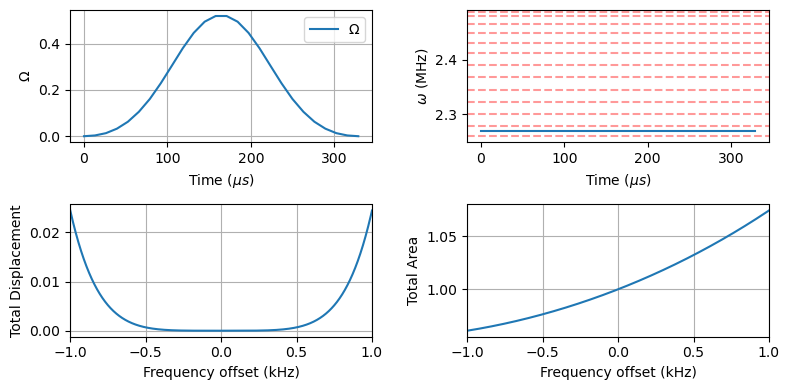

In [82]:
# === Review results & save ===
opt_raw_params, metadata = get_metadata_and_plot(nlmodel, best_params, nseg, sysparams, modes)
println(JSON.json(metadata, 4))
save_am_solution(out_file, opt_raw_params, metadata, sysparams, ion1, ion2)

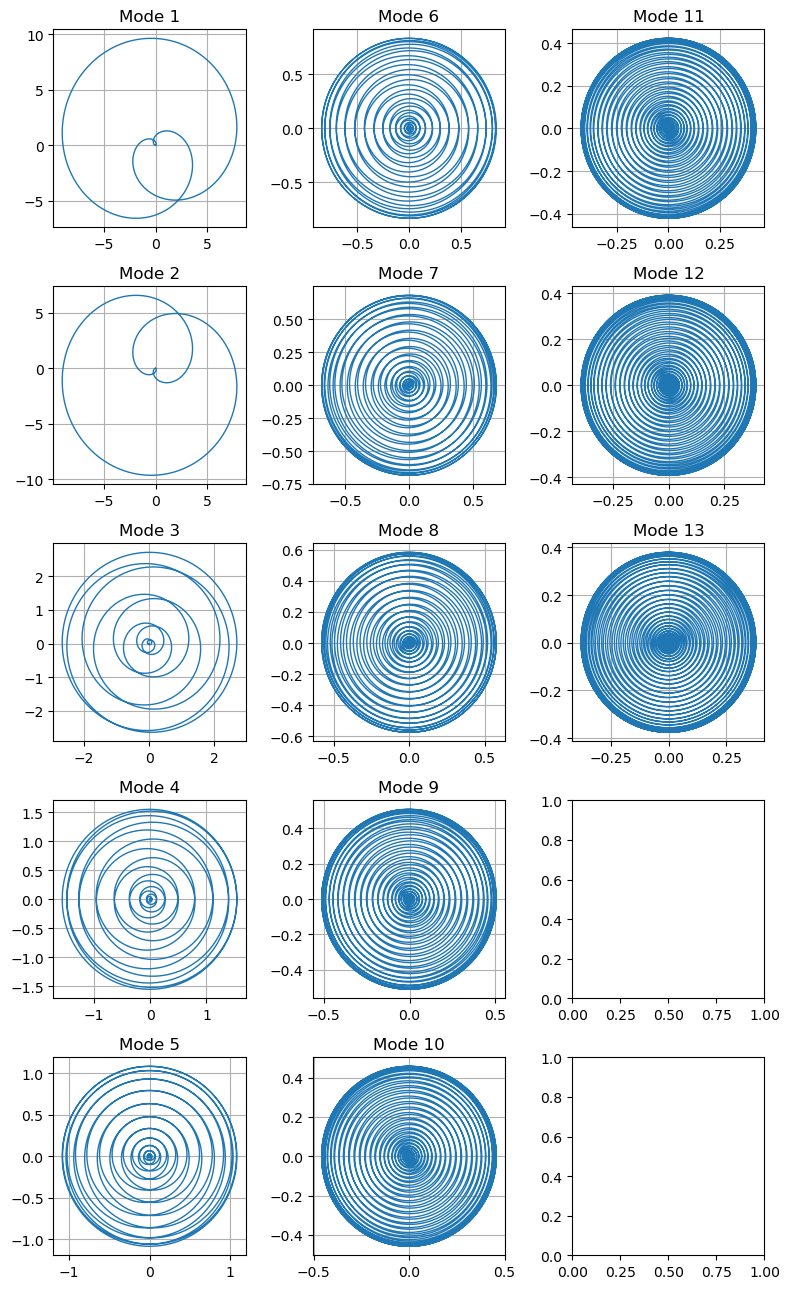

In [83]:
# === Trajectory plots (optional) ===
plot_trajectories(opt_raw_params, modes)